In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm

# Problema de Dois corpos

Equações de Newton para o problema de Múltiplos corpos:

$$ 
\begin{align}
m_i \boldsymbol{\ddot{r}_i} = - \sum_{j=1, i \ne j}^{n} \frac{\gamma m_i m_j (\boldsymbol{r}_i - \boldsymbol{r}_j)}{\| \boldsymbol{r}_i - \boldsymbol{r}_j \|^3}, i = 1,2,...,n 
\end{align}
$$

Para o problema de dois corpos fica reduzido a:

$$
\begin{cases}
m_1\boldsymbol{\ddot{r}_1} = - \frac{\gamma m_1 m_2(\boldsymbol{r}_1 - \boldsymbol{r}_2)}{\| \boldsymbol{r_1} - \boldsymbol{r_2} \|^3} \\
m_2\boldsymbol{\ddot{r}_2} = - \frac{\gamma m_2 m_1(\boldsymbol{r}_2 - \boldsymbol{r}_1)}{\| \boldsymbol{r_2} - \boldsymbol{r_1} \|^3} 
\end{cases}
$$

Que, abrindo componente a componente fica:

$$
\begin{cases}
m_1\ddot{r}_{1x} = - \frac{\gamma m_1 m_2(r_{1x} - r_{2x})}{\sqrt{\left((r_{1x}-r_{2x})^2 + (r_{1y} - r_{2y})^2\right)}^3} \\
m_1\ddot{r}_{1y} = - \frac{\gamma m_1 m_2(r_{1y} - r_{2y})}{\sqrt{\left((r_{1x}-r_{2x})^2 + (r_{1y} - r_{2y})^2\right)}^3} \\
m_2\ddot{r}_{2x} = - \frac{\gamma m_2 m_1(r_{2x} - r_{1x})}{\sqrt{\left((r_{2x}-r_{1x})^2 + (r_{2y} - r_{1y})^2\right)}^3} \\
m_2\ddot{r}_{2y} = - \frac{\gamma m_2 m_1(r_{2y} - r_{1y})}{\sqrt{\left((r_{2x}-r_{1x})^2 + (r_{2y} - r_{1y})^2\right)}^3} 
\end{cases}
$$

Que, eliminando os $m_1$, $m_2$ redundantes e assumindo $(\dot{r}_i) = v_i$, temos:

$$
\begin{cases}
\dot{r}_{1x} = v_{1x} \\
\dot{r}_{1y} = v_{1y} \\
\dot{r}_{2x} = v_{2x} \\
\dot{r}_{2y} = v_{2y} \\
\dot{v}_{1x} = - \frac{\gamma m_2 (r_{1x} - r_{2x})}{\sqrt{\left((r_{1x}-r_{2x})^2 + (r_{1y} - r_{2y})^2\right)}^3} \\
\dot{v}_{1y} = - \frac{\gamma m_2 (r_{1y} - r_{2y})}{\sqrt{\left((r_{1x}-r_{2x})^2 + (r_{1y} - r_{2y})^2\right)}^3} \\
\dot{v}_{2x} = - \frac{\gamma m_1 (r_{2x} - r_{1x})}{\sqrt{\left((r_{2x}-r_{1x})^2 + (r_{2y} - r_{1y})^2\right)}^3} \\
\dot{v}_{2y} = - \frac{\gamma m_1 (r_{2y} - r_{1y})}{\sqrt{\left((r_{2x}-r_{1x})^2 + (r_{2y} - r_{1y})^2\right)}^3} 
\end{cases}
$$

E podemos resolver o problema dos dois corpos com métodos numéricos tradicionais.

O exemplo escolhido é uma configuração estável, com dois corpos de mesmo peso e velocidade inicial direção contrária e de mesmo módulo, gerando uma configuração de duas elipses, com um objeto sempre estando em posição focal para a órbita do outro objeto. O centro de massa não se movimenta.

In [2]:
# Helper plot functions
def pplot(tn, un, label):
    fig, ax = plt.subplots()
    plt.plot(tn, un, label=label)
    ax.set_axisbelow(True)
    ax.minorticks_on()
    ax.grid(which='major', linestyle='-', linewidth='0.5', color='red')
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    plt.title("Numeric solution of Differential Equation")
    plt.legend()
    ax = plt.gca()

def pplot2(tn1, un1, label1, tn2, un2, label2):
    fig, ax = plt.subplots()
    plt.plot(tn1, un1, label=label1)
    plt.plot(tn2, un2, label=label2)
    ax.set_axisbelow(True)
    ax.minorticks_on()
    ax.grid(which='major', linestyle='-', linewidth='0.5', color='red')
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    plt.title("Numeric solution of Differential Equation")
    plt.legend()
    ax = plt.gca()

In [3]:
# Runge-Kutta4 implementation:
def evaluate_runge_kutta(f, u0, h = 0.0001, start = 0, finish = 60):
    # With h = 0.0001, the solutions of the two body problems 
    # become stable (which they are), so this is the base value of h:
    t = [start]
    u = [u0]
    i = 1
    pbar = tqdm(total=int((finish-start)/h))
    while t[-1] < finish:
        tn = t[-1]
        un = u[-1]
        k1 = f(tn, un)
        k2 = f(tn + h/2, un + (h/2)*k1)
        k3 = f(tn + h/2, un + (h/2)*k2)
        k4 = f(tn + h, un + h*k3)
        t.append(t[-1] + h)
        u.append(un + (h/6)*(k1 + 2*k2 + 2*k3 + k4))
        i = i + 1
        pbar.update(1)
    pbar.close()
    return np.vstack((np.transpose(t), np.transpose(u)))

In [4]:
# Verlet implementation:
def evaluate_verlet(f, u0, h = 0.1, start = 0, finish = 60):
    # Using steps a thousand bigger than Runge-Kutta, since Verlet Method is much more stable.
    # The first half members of f, u0 are position, last half members of f,u0 are velocity.
    t = [start]
    u = [u0]
    i = 1
    
    # To make sure function format is correct:
    f0 = f(start, u0)
    
    if(len(f0) != len(u0)):
        raise Exception("Function and initial values must have the same length.")
    
    if(len(f0) % 2 != 0):
        raise Exception("Length of f and u0 must be even.")
        
    pbar = tqdm(total=int((finish-start)/h))
    while t[-1] < finish:
        tn = np.array(t[-1])
        un = np.array(u[-1])
        un1 = np.array(f(tn, un))
        rn = np.array(un[:int(len(un)/2)])
        vn = np.array(un[-int(len(un)/2):])
        an = np.array(un1[-int(len(un)/2):])
        if(i == 1):
            r = rn + h * vn + (h*h/2) * an
        else:
            un_1 = u[-2]
            rn_1 = un_1[:int(len(un_1)/2)]
            r = 2 * rn - rn_1 + (h*h) * an
            v_1 = (r - rn_1)/(2*h)
            # Assign v retroactively:
            u[-1][-int(len(u[-1])/2):] = v_1
        v = np.zeros(len(vn))
        u.append(np.concatenate((r,v)))
        t.append(t[-1] + h)
        i = i + 1
        pbar.update(1)
    pbar.close()
    # Assign last velocity to previous one, to avoid plot breaks:
    u[-1][-int(len(u[-1])/2):] = u[-2][-int(len(u[-1])/2):]
    return np.vstack((np.transpose(t), np.transpose(u)))

In [5]:
# Two Body system function:
def two_body(t, u): # t (time) parameter is ignored, since the equations are autonomous
    # Constants:
    gamma = 1
    m1 = 1
    m2 = 1
    
    # Input parameters:
    r_1x = u[0]
    r_1y = u[1]
    r_2x = u[2]
    r_2y = u[3]
    v_1x = u[4]
    v_1y = u[5]
    v_2x = u[6]
    v_2y = u[7]
    
    # Evaluation:
    dr_1x = v_1x
    dr_1y = v_1y
    dr_2x = v_2x
    dr_2y = v_2y
    dv_1x = - (gamma * m2 *(r_1x - r_2x))/(((r_1x - r_2x)**2 + (r_1y - r_2y)**2)**(3/2))
    dv_1y = - (gamma * m2 *(r_1y - r_2y))/(((r_1x - r_2x)**2 + (r_1y - r_2y)**2)**(3/2))
    dv_2x = - (gamma * m1 *(r_2x - r_1x))/(((r_2x - r_1x)**2 + (r_2y - r_1y)**2)**(3/2))
    dv_2y = - (gamma * m1 *(r_2y - r_1y))/(((r_2x - r_1x)**2 + (r_2y - r_1y)**2)**(3/2))
    return np.array([dr_1x,dr_1y,dr_2x,dr_2y,dv_1x,dv_1y,dv_2x,dv_2y])

## Solução de 2-corpos com o Método de Runge-Kutta:

100%|████████████████████████████████| 600000/600000 [00:12<00:00, 48584.98it/s]


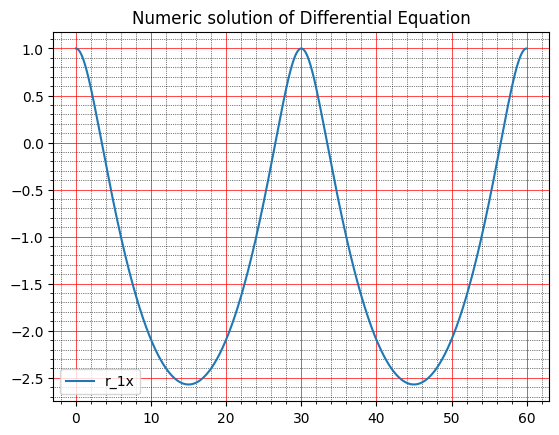

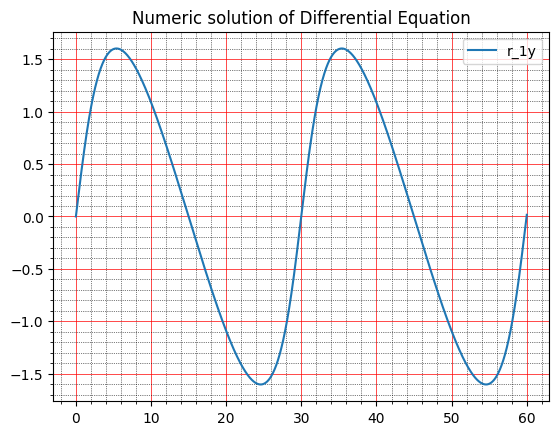

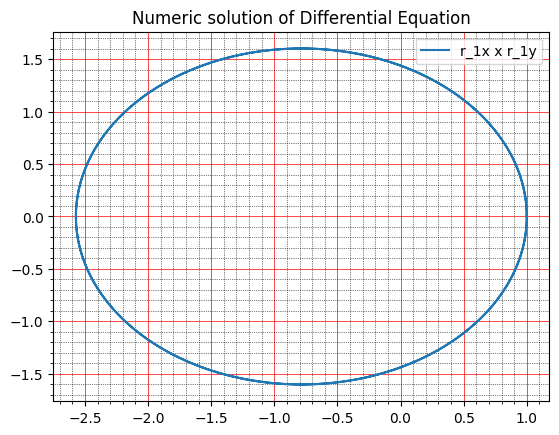

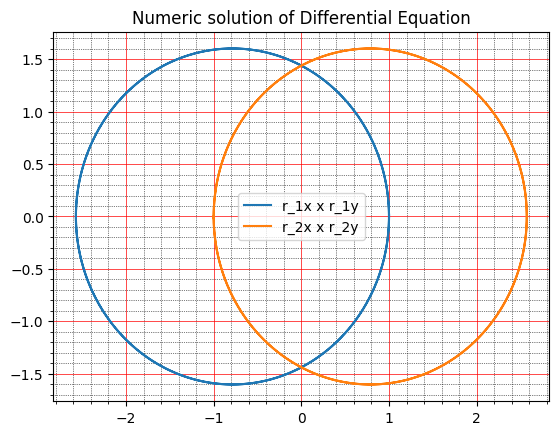

In [6]:
simulation_rk = evaluate_runge_kutta(two_body, [1, 0, -1, 0, 0, 0.6, 0, -0.6])
pplot(simulation_rk[0], simulation_rk[1], "r_1x")
pplot(simulation_rk[0], simulation_rk[2], "r_1y")
pplot(simulation_rk[1], simulation_rk[2], "r_1x x r_1y")
pplot2(simulation_rk[1], simulation_rk[2], "r_1x x r_1y", simulation_rk[3], simulation_rk[4], "r_2x x r_2y")

## Solução de 2-corpos com Método de Verlet:

100%|██████████████████████████████████████| 600/600 [00:00<00:00, 68936.13it/s]


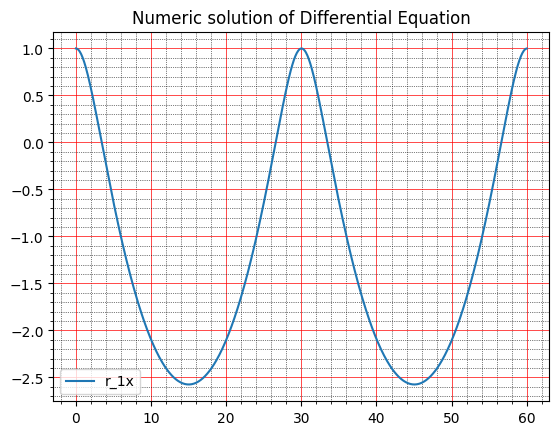

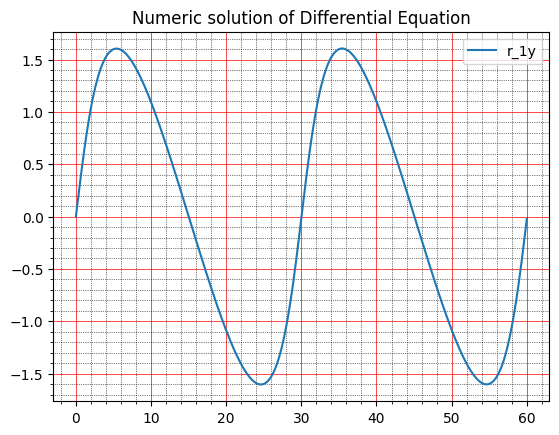

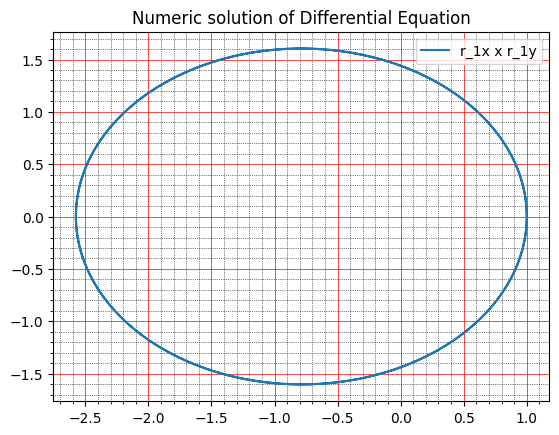

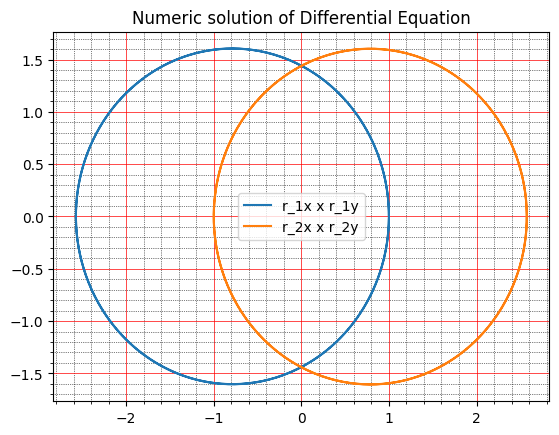

In [7]:
simulation_v = evaluate_verlet(two_body, [1, 0, -1, 0, 0, 0.6, 0, -0.6])
pplot(simulation_v[0], simulation_v[1], "r_1x")
pplot(simulation_v[0], simulation_v[2], "r_1y")
pplot(simulation_v[1], simulation_v[2], "r_1x x r_1y")
pplot2(simulation_v[1], simulation_v[2], "r_1x x r_1y", simulation_v[3], simulation_v[4], "r_2x x r_2y")

# O Problema de Três Corpos

Uma vez testada uma solução estável para o Problema de Dois Corpos, podemos agora trabalhar em cima do Problema de Três Corpos.

Relembrando as equações de Newton para o problema de Múltiplos corpos:

$$ 
\begin{align}
m_i \boldsymbol{\ddot{r}_i} = - \sum_{j=1, i \ne j}^{n} \frac{\gamma m_i m_j (\boldsymbol{r}_i - \boldsymbol{r}_j)}{\| \boldsymbol{r}_i - \boldsymbol{r}_j \|^3}, i = 1,2,...,n 
\end{align}
$$

Para o problema de três corpos fica reduzido a:

$$
\begin{cases}
m_1\boldsymbol{\ddot{r}_1} = - \left(\frac{\gamma m_1 m_2(\boldsymbol{r}_1 - \boldsymbol{r}_2)}{\| \boldsymbol{r_1} - \boldsymbol{r_2} \|^3} + \frac{\gamma m_1 m_3(\boldsymbol{r}_1 - \boldsymbol{r}_3)}{\| \boldsymbol{r_1} - \boldsymbol{r_3} \|^3}\right) \\
m_2\boldsymbol{\ddot{r}_2} = - \left(\frac{\gamma m_2 m_1(\boldsymbol{r}_2 - \boldsymbol{r}_1)}{\| \boldsymbol{r_2} - \boldsymbol{r_1} \|^3} + \frac{\gamma m_2 m_3(\boldsymbol{r}_2 - \boldsymbol{r}_3)}{\| \boldsymbol{r_2} - \boldsymbol{r_3} \|^3}\right) \\
m_3\boldsymbol{\ddot{r}_3} = - \left(\frac{\gamma m_3 m_1(\boldsymbol{r}_3 - \boldsymbol{r}_1)}{\| \boldsymbol{r_3} - \boldsymbol{r_1} \|^3} + \frac{\gamma m_3 m_2(\boldsymbol{r}_3 - \boldsymbol{r}_2)}{\| \boldsymbol{r_3} - \boldsymbol{r_2} \|^3}\right) 
\end{cases}
$$

Que, eliminando os $m_i$, redundantes e assumindo $(\dot{r}_i) = v_i$, temos:

$$
\begin{cases}
\dot{r}_{1x} = v_{1x} \\
\dot{r}_{1y} = v_{1y} \\
\dot{r}_{2x} = v_{2x} \\
\dot{r}_{2y} = v_{2y} \\
\dot{r}_{3x} = v_{3x} \\
\dot{r}_{3y} = v_{3y} \\
\dot{v}_{1x} = - \left(\frac{\gamma m_2 (r_{1x} - r_{2x})}{\sqrt{\left((r_{1x}-r_{2x})^2 + (r_{1y} - r_{2y})^2\right)}^3} + \frac{\gamma m_3 (r_{1x} - r_{3x})}{\sqrt{\left((r_{1x}-r_{3x})^2 + (r_{1y} - r_{3y})^2\right)}^3}\right) \\
\dot{v}_{1y} = - \left(\frac{\gamma m_2 (r_{1y} - r_{2y})}{\sqrt{\left((r_{1x}-r_{2x})^2 + (r_{1y} - r_{2y})^2\right)}^3} + \frac{\gamma m_3 (r_{1y} - r_{3y})}{\sqrt{\left((r_{1x}-r_{3x})^2 + (r_{1y} - r_{3y})^2\right)}^3}\right)\\
\dot{v}_{2x} = - \left(\frac{\gamma m_1 (r_{2x} - r_{1x})}{\sqrt{\left((r_{2x}-r_{1x})^2 + (r_{2y} - r_{1y})^2\right)}^3} + \frac{\gamma m_3 (r_{2x} - r_{3x})}{\sqrt{\left((r_{2x}-r_{3x})^2 + (r_{2y} - r_{3y})^2\right)}^3}\right) \\
\dot{v}_{2y} = - \left(\frac{\gamma m_1 (r_{2y} - r_{1y})}{\sqrt{\left((r_{2x}-r_{1x})^2 + (r_{2y} - r_{1y})^2\right)}^3} + \frac{\gamma m_3 (r_{2y} - r_{3y})}{\sqrt{\left((r_{2x}-r_{3x})^2 + (r_{2y} - r_{3y})^2\right)}^3}\right)\\
\dot{v}_{3x} = - \left(\frac{\gamma m_1 (r_{3x} - r_{1x})}{\sqrt{\left((r_{3x}-r_{1x})^2 + (r_{3y} - r_{1y})^2\right)}^3} + \frac{\gamma m_2 (r_{3x} - r_{2x})}{\sqrt{\left((r_{3x}-r_{2x})^2 + (r_{3y} - r_{2y})^2\right)}^3}\right) \\
\dot{v}_{3y} = - \left(\frac{\gamma m_1 (r_{3y} - r_{1y})}{\sqrt{\left((r_{3x}-r_{1x})^2 + (r_{3y} - r_{1y})^2\right)}^3} + \frac{\gamma m_2 (r_{3y} - r_{2y})}{\sqrt{\left((r_{3x}-r_{2x})^2 + (r_{3y} - r_{2y})^2\right)}^3}\right)
\end{cases}
$$


In [8]:
# Three Body system function:
def three_body(t, u): # t (time) parameter is ignored, since the equations are autonomous
    # Constants:
    gamma = 1
    m1 = 1
    m2 = 1
    m3 = 1
    
    # Input parameters:
    r_1x = u[0]
    r_1y = u[1]
    r_2x = u[2]
    r_2y = u[3]
    r_3x = u[4]
    r_3y = u[5]
    v_1x = u[6]
    v_1y = u[7]
    v_2x = u[8]
    v_2y = u[9]
    v_3x = u[10]
    v_3y = u[11]
    
    # Evaluation:
    dr_1x = v_1x
    dr_1y = v_1y
    dr_2x = v_2x
    dr_2y = v_2y
    dr_3x = v_3x
    dr_3y = v_3y
    dv_1x = - ((gamma * m2 *(r_1x - r_2x))/(((r_1x - r_2x)**2 + (r_1y - r_2y)**2)**(3/2)) + (gamma * m3 *(r_1x - r_3x))/(((r_1x - r_3x)**2 + (r_1y - r_3y)**2)**(3/2)))
    dv_1y = - ((gamma * m2 *(r_1y - r_2y))/(((r_1x - r_2x)**2 + (r_1y - r_2y)**2)**(3/2)) + (gamma * m3 *(r_1y - r_3y))/(((r_1x - r_3x)**2 + (r_1y - r_3y)**2)**(3/2)))
    dv_2x = - ((gamma * m1 *(r_2x - r_1x))/(((r_2x - r_1x)**2 + (r_2y - r_1y)**2)**(3/2)) + (gamma * m3 *(r_2x - r_3x))/(((r_2x - r_3x)**2 + (r_2y - r_3y)**2)**(3/2)))
    dv_2y = - ((gamma * m1 *(r_2y - r_1y))/(((r_2x - r_1x)**2 + (r_2y - r_1y)**2)**(3/2)) + (gamma * m3 *(r_2y - r_3y))/(((r_2x - r_3x)**2 + (r_2y - r_3y)**2)**(3/2)))
    dv_3x = - ((gamma * m1 *(r_3x - r_1x))/(((r_3x - r_1x)**2 + (r_3y - r_1y)**2)**(3/2)) + (gamma * m2 *(r_3x - r_2x))/(((r_3x - r_2x)**2 + (r_3y - r_2y)**2)**(3/2)))
    dv_3y = - ((gamma * m1 *(r_3y - r_1y))/(((r_3x - r_1x)**2 + (r_3y - r_1y)**2)**(3/2)) + (gamma * m2 *(r_3y - r_2y))/(((r_3x - r_2x)**2 + (r_3y - r_2y)**2)**(3/2)))
    return np.array([dr_1x,dr_1y,dr_2x,dr_2y,dr_3x,dr_3y,dv_1x,dv_1y,dv_2x,dv_2y,dv_3x,dv_3y])

In [9]:
# Helper plot function:
def pplot3(tn1, un1, label1, tn2, un2, label2, tn3, un3, label3):
    fig, ax = plt.subplots()
    plt.plot(tn1, un1, label=label1)
    plt.plot(tn2, un2, label=label2)
    plt.plot(tn3, un3, label=label3)
    ax.set_axisbelow(True)
    ax.minorticks_on()
    ax.grid(which='major', linestyle='-', linewidth='0.5', color='red')
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    plt.title("Numeric solution of Differential Equation")
    plt.legend()
    ax = plt.gca()

## Solução de 3-corpos com o Método de Runge-Kutta:

100%|████████████████████████████████| 600000/600000 [00:22<00:00, 26488.72it/s]


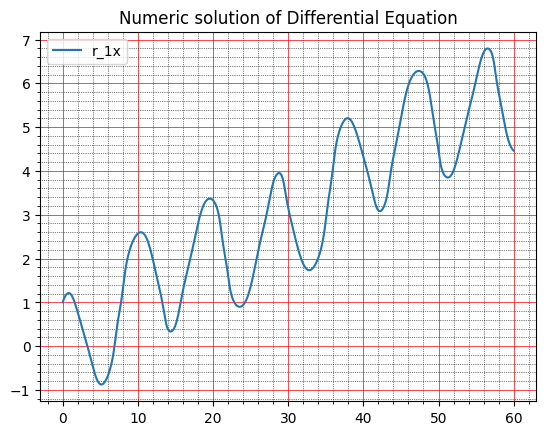

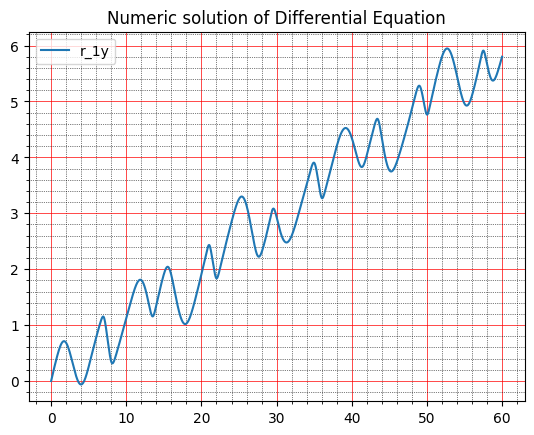

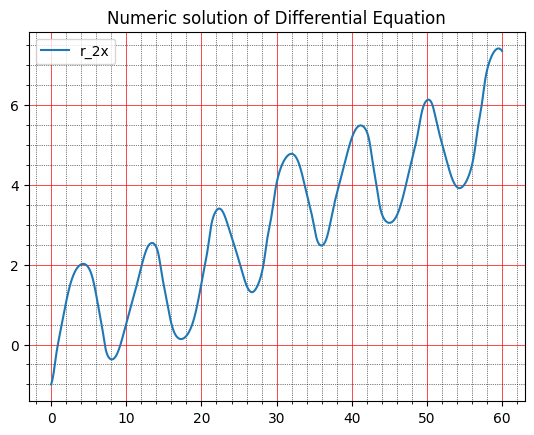

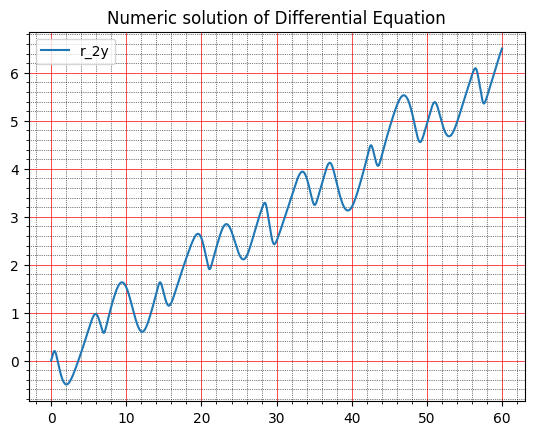

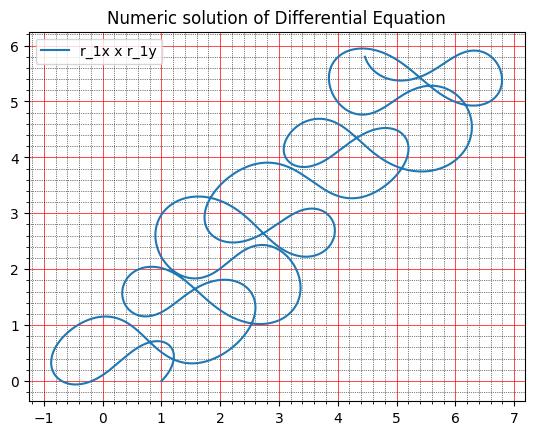

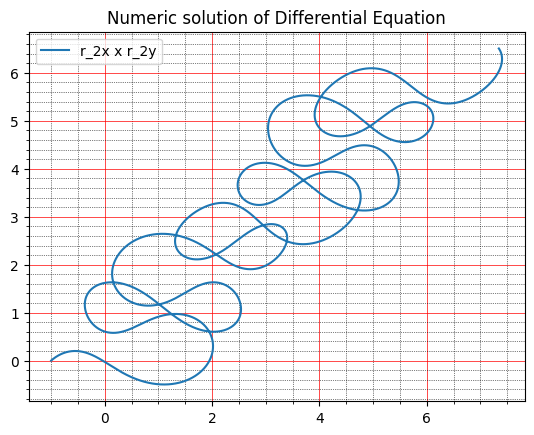

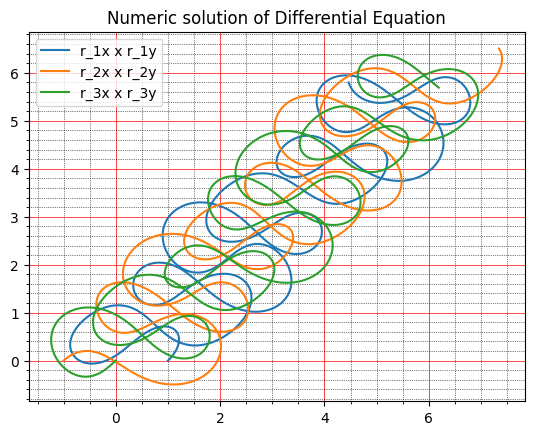

In [10]:
simulation3_rk = evaluate_runge_kutta(three_body, [1, 0, -1, 0, 0, 0, 0.6, 0.6, 0.6, 0.6, -0.9, -0.9])
pplot(simulation3_rk[0], simulation3_rk[1], "r_1x")
pplot(simulation3_rk[0], simulation3_rk[2], "r_1y")
pplot(simulation3_rk[0], simulation3_rk[3], "r_2x")
pplot(simulation3_rk[0], simulation3_rk[4], "r_2y")
pplot(simulation3_rk[1], simulation3_rk[2], "r_1x x r_1y")
pplot(simulation3_rk[3], simulation3_rk[4], "r_2x x r_2y")
pplot3(simulation3_rk[1], simulation3_rk[2], "r_1x x r_1y",
       simulation3_rk[3], simulation3_rk[4], "r_2x x r_2y",
       simulation3_rk[5], simulation3_rk[6], "r_3x x r_3y")


100%|██████████████████████████████████████| 600/600 [00:00<00:00, 48829.65it/s]


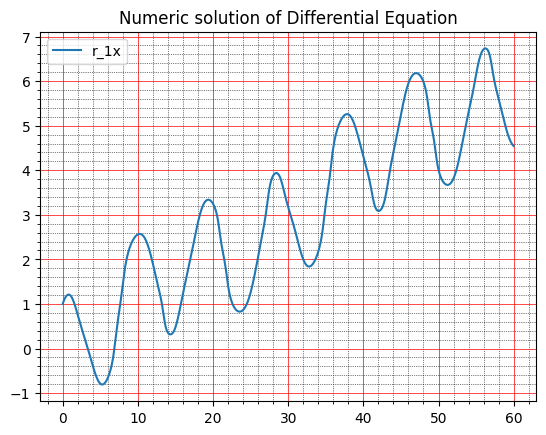

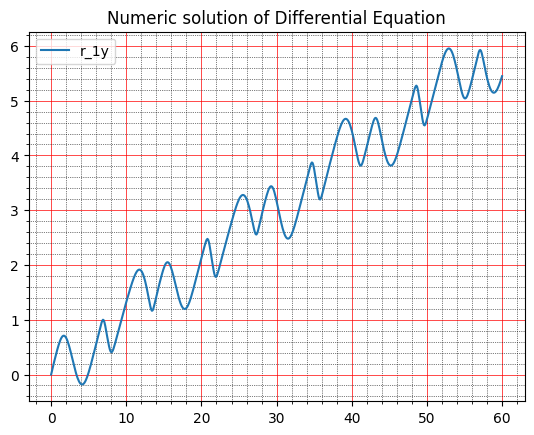

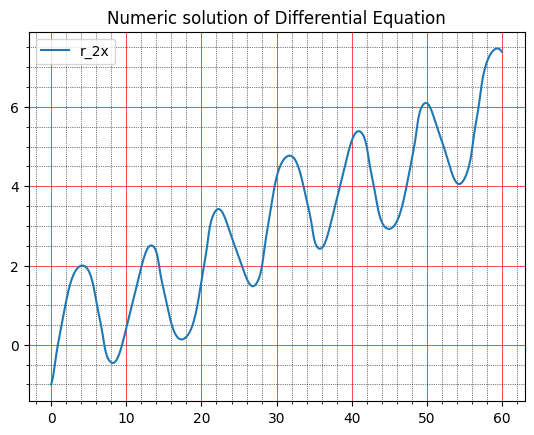

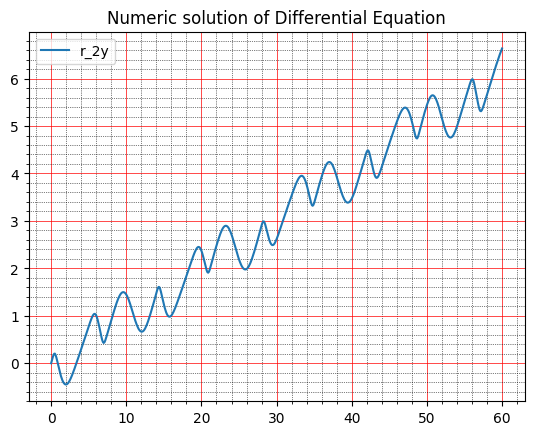

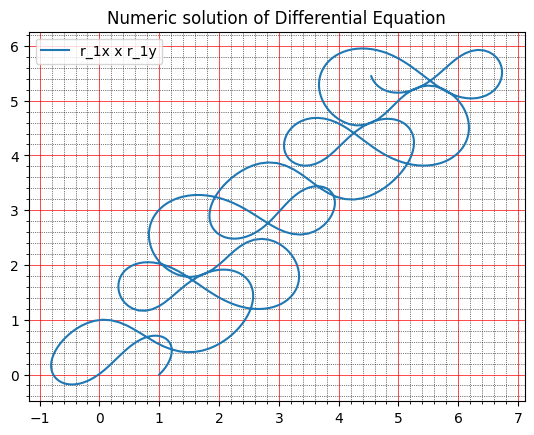

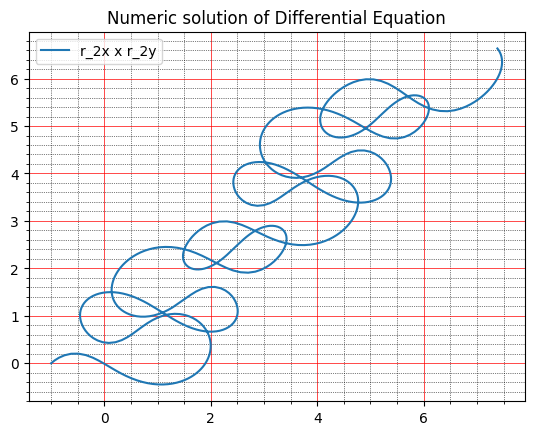

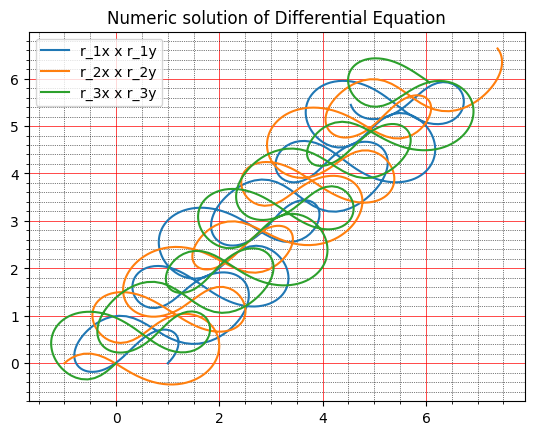

In [11]:
simulation3_v = evaluate_verlet(three_body, [1, 0, -1, 0, 0, 0, 0.6, 0.6, 0.6, 0.6, -0.9, -0.9])
pplot(simulation3_v[0], simulation3_v[1], "r_1x")
pplot(simulation3_v[0], simulation3_v[2], "r_1y")
pplot(simulation3_v[0], simulation3_v[3], "r_2x")
pplot(simulation3_v[0], simulation3_v[4], "r_2y")
pplot(simulation3_v[1], simulation3_v[2], "r_1x x r_1y")
pplot(simulation3_v[3], simulation3_v[4], "r_2x x r_2y")
pplot3(simulation3_v[1], simulation3_v[2], "r_1x x r_1y",
       simulation3_v[3], simulation3_v[4], "r_2x x r_2y",
       simulation3_v[5], simulation3_v[6], "r_3x x r_3y")

## Solução estável, número #2

$$
v_1 = (0.322184765624991, 0.647989160156249) \\
v_2 = (0.322184765624991, 0.647989160156249) \\
v_3 = (-0.644369531249982, -1.295978320312498) \\
$$

### Método de Runge-Kutta

In [ ]:
simulation3_rk = evaluate_runge_kutta(three_body, [-1, 0, 1, 0, 0, 0, 0.322184765624991,0.647989160156249, 0.322184765624991,0.647989160156249, -0.644369531249982,-1.295978320312498], h=0.00001, finish=17.12)
pplot(simulation3_rk[0], simulation3_rk[1], "r_1x")
pplot(simulation3_rk[0], simulation3_rk[2], "r_1y")
pplot(simulation3_rk[0], simulation3_rk[3], "r_2x")
pplot(simulation3_rk[0], simulation3_rk[4], "r_2y")
pplot(simulation3_rk[1], simulation3_rk[2], "r_1x x r_1y")
pplot(simulation3_rk[3], simulation3_rk[4], "r_2x x r_2y")
pplot3(simulation3_rk[1], simulation3_rk[2], "r_1x x r_1y",
       simulation3_rk[3], simulation3_rk[4], "r_2x x r_2y",
       simulation3_rk[5], simulation3_rk[6], "r_3x x r_3y")

 96%|████████████████████████████▉ | 1650198/1712000 [01:02<00:02, 26672.86it/s]

### Método de Verlet

In [ ]:
simulation3_v = evaluate_verlet(three_body, [-1, 0, 1, 0, 0, 0, 0.322184765624991,0.647989160156249, 0.322184765624991,0.647989160156249, -0.644369531249982,-1.295978320312498], h=0.002, finish=17.12)
pplot(simulation3_v[0], simulation3_v[1], "r_1x")
pplot(simulation3_v[0], simulation3_v[2], "r_1y")
pplot(simulation3_v[0], simulation3_v[3], "r_2x")
pplot(simulation3_v[0], simulation3_v[4], "r_2y")
pplot(simulation3_v[1], simulation3_v[2], "r_1x x r_1y")
pplot(simulation3_v[3], simulation3_v[4], "r_2x x r_2y")
pplot3(simulation3_v[1], simulation3_v[2], "r_1x x r_1y",
       simulation3_v[3], simulation3_v[4], "r_2x x r_2y",
       simulation3_v[5], simulation3_v[6], "r_3x x r_3y")

## Solução estável, número #3

$$
v_1 = (0.257841699218752, 0.687880761718747) \\
v_2 = (0.257841699218752, 0.687880761718747) \\
v_3 = (-0.515683398437504, -1.375761523437494) \\
$$

### Método de Runge-Kutta

In [ ]:
simulation3_rk = evaluate_runge_kutta(three_body, [-1, 0, 1, 0, 0, 0, 0.257841699218752, 0.687880761718747, 0.257841699218752, 0.687880761718747, -0.515683398437504, -1.375761523437494], h=0.00001, finish=1)
pplot(simulation3_rk[0], simulation3_rk[1], "r_1x")
pplot(simulation3_rk[0], simulation3_rk[2], "r_1y")
pplot(simulation3_rk[0], simulation3_rk[3], "r_2x")
pplot(simulation3_rk[0], simulation3_rk[4], "r_2y")
pplot(simulation3_rk[1], simulation3_rk[2], "r_1x x r_1y")
pplot(simulation3_rk[3], simulation3_rk[4], "r_2x x r_2y")
pplot3(simulation3_rk[1], simulation3_rk[2], "r_1x x r_1y",
       simulation3_rk[3], simulation3_rk[4], "r_2x x r_2y",
       simulation3_rk[5], simulation3_rk[6], "r_3x x r_3y")

### Método de Verlet

In [ ]:
simulation3_v = evaluate_verlet(three_body, [-1, 0, 1, 0, 0, 0, 0.257841699218752, 0.687880761718747, 0.257841699218752, 0.687880761718747, -0.515683398437504, -1.375761523437494], h=0.002, finish=1)
pplot(simulation3_v[0], simulation3_v[1], "r_1x")
pplot(simulation3_v[0], simulation3_v[2], "r_1y")
pplot(simulation3_v[0], simulation3_v[3], "r_2x")
pplot(simulation3_v[0], simulation3_v[4], "r_2y")
pplot(simulation3_v[1], simulation3_v[2], "r_1x x r_1y")
pplot(simulation3_v[3], simulation3_v[4], "r_2x x r_2y")
pplot3(simulation3_v[1], simulation3_v[2], "r_1x x r_1y",
       simulation3_v[3], simulation3_v[4], "r_2x x r_2y",
       simulation3_v[5], simulation3_v[6], "r_3x x r_3y")

## Solução estável, número #4

$$
v_1 = (0.568991007042164, 0.449428951346711) \\
v_2 = (0.568991007042164, 0.449428951346711) \\
v_3 = (-1.137982014084328, -0.898857902693422) \\
$$

### Método de Runge-Kutta

In [ ]:
simulation3_rk = evaluate_runge_kutta(three_body, [-1, 0, 1, 0, 0, 0, 0.568991007042164, 0.449428951346711, 0.568991007042164, 0.449428951346711, -1.137982014084328, -0.898857902693422], h=0.00001, finish=1)
pplot(simulation3_rk[0], simulation3_rk[1], "r_1x")
pplot(simulation3_rk[0], simulation3_rk[2], "r_1y")
pplot(simulation3_rk[0], simulation3_rk[3], "r_2x")
pplot(simulation3_rk[0], simulation3_rk[4], "r_2y")
pplot(simulation3_rk[1], simulation3_rk[2], "r_1x x r_1y")
pplot(simulation3_rk[3], simulation3_rk[4], "r_2x x r_2y")
pplot3(simulation3_rk[1], simulation3_rk[2], "r_1x x r_1y",
       simulation3_rk[3], simulation3_rk[4], "r_2x x r_2y",
       simulation3_rk[5], simulation3_rk[6], "r_3x x r_3y")

### Método de Verlet

In [ ]:
simulation3_v = evaluate_verlet(three_body, [-1, 0, 1, 0, 0, 0, 0.568991007042164, 0.449428951346711, 0.568991007042164, 0.449428951346711, -1.137982014084328, -0.898857902693422], h=0.002, finish=1)
pplot(simulation3_v[0], simulation3_v[1], "r_1x")
pplot(simulation3_v[0], simulation3_v[2], "r_1y")
pplot(simulation3_v[0], simulation3_v[3], "r_2x")
pplot(simulation3_v[0], simulation3_v[4], "r_2y")
pplot(simulation3_v[1], simulation3_v[2], "r_1x x r_1y")
pplot(simulation3_v[3], simulation3_v[4], "r_2x x r_2y")
pplot3(simulation3_v[1], simulation3_v[2], "r_1x x r_1y",
       simulation3_v[3], simulation3_v[4], "r_2x x r_2y",
       simulation3_v[5], simulation3_v[6], "r_3x x r_3y")

## Solução estável, número #22

$$
v_1 = (0.698073236083981, 0.328500769042967) \\
v_2 = (0.698073236083981, 0.328500769042967) \\
v_3 = (-1.396146472167962, -0.657001538085934) \\
$$

### Método de Runge-Kutta

In [ ]:
simulation3_rk = evaluate_runge_kutta(three_body, [-1, 0, 1, 0, 0, 0, 0.698073236083981, 0.328500769042967, 0.698073236083981, 0.328500769042967,-1.396146472167962, -0.657001538085934], h=0.00001, finish=1)
pplot(simulation3_rk[0], simulation3_rk[1], "r_1x")
pplot(simulation3_rk[0], simulation3_rk[2], "r_1y")
pplot(simulation3_rk[0], simulation3_rk[3], "r_2x")
pplot(simulation3_rk[0], simulation3_rk[4], "r_2y")
pplot(simulation3_rk[1], simulation3_rk[2], "r_1x x r_1y")
pplot(simulation3_rk[3], simulation3_rk[4], "r_2x x r_2y")
pplot3(simulation3_rk[1], simulation3_rk[2], "r_1x x r_1y",
       simulation3_rk[3], simulation3_rk[4], "r_2x x r_2y",
       simulation3_rk[5], simulation3_rk[6], "r_3x x r_3y")

### Método de Verlet

In [ ]:
simulation3_v = evaluate_verlet(three_body, [-1, 0, 1, 0, 0, 0, 0.698073236083981, 0.328500769042967, 0.698073236083981, 0.328500769042967,-1.396146472167962, -0.657001538085934], h=0.002, finish=17.12)
pplot(simulation3_v[0], simulation3_v[1], "r_1x")
pplot(simulation3_v[0], simulation3_v[2], "r_1y")
pplot(simulation3_v[0], simulation3_v[3], "r_2x")
pplot(simulation3_v[0], simulation3_v[4], "r_2y")
pplot(simulation3_v[1], simulation3_v[2], "r_1x x r_1y")
pplot(simulation3_v[3], simulation3_v[4], "r_2x x r_2y")
pplot3(simulation3_v[1], simulation3_v[2], "r_1x x r_1y",
       simulation3_v[3], simulation3_v[4], "r_2x x r_2y",
       simulation3_v[5], simulation3_v[6], "r_3x x r_3y")